In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import datetime


import warnings
warnings.filterwarnings('ignore')

In [2]:
config = f"""
dataset: 
    competition_dir: /kaggle/input/child-mind-institute-detect-sleep-states
    cv_split_path: /kaggle/input/cv_split/train_folds.csv

seed: 46
"""

CFG = yaml.load(config, Loader=yaml.SafeLoader)

In [3]:
train = pd.read_parquet(f"{CFG['dataset']['competition_dir']}/train_series.parquet")
train["date"] = train["timestamp"].str[:10]
train = train.drop_duplicates(subset=["date", "series_id"])[["series_id", "date"]]
print(train.shape)
train.head()

(7703, 2)


,series_id,date
0,038441c925bb,2018-08-14
6120,038441c925bb,2018-08-15
23400,038441c925bb,2018-08-16
40680,038441c925bb,2018-08-17
57960,038441c925bb,2018-08-18


In [4]:
# 予測形式に変える
# wakeupは11時中心(前日23:00~当日22:59), onsetは24時中心(当日12:00~翌日11:59)
wakeup_df = train.copy()
wakeup_df["start_time"] = pd.to_datetime(wakeup_df["date"] + " 23:00:00", utc=True) - pd.offsets.Day(1)
wakeup_df["end_time"] = pd.to_datetime(wakeup_df["date"] + " 22:59:59", utc=True)
wakeup_df["target_type"] = "wakeup"

onset_df = train.copy()
onset_df["start_time"] = pd.to_datetime(onset_df["date"] + " 14:00:00", utc=True)
onset_df["end_time"] = pd.to_datetime(onset_df["date"] + " 13:59:59", utc=True) + pd.offsets.Day(1)
onset_df["target_type"] = "onset"

train = pd.concat([wakeup_df, onset_df], axis=0).drop(columns=["date"])
train

,series_id,start_time,end_time,target_type
0,038441c925bb,2018-08-13 23:00:00+00:00,2018-08-14 22:59:59+00:00,wakeup
6120,038441c925bb,2018-08-14 23:00:00+00:00,2018-08-15 22:59:59+00:00,wakeup
23400,038441c925bb,2018-08-15 23:00:00+00:00,2018-08-16 22:59:59+00:00,wakeup
40680,038441c925bb,2018-08-16 23:00:00+00:00,2018-08-17 22:59:59+00:00,wakeup
57960,038441c925bb,2018-08-17 23:00:00+00:00,2018-08-18 22:59:59+00:00,wakeup
...,...,...,...,...
127877040,fe90110788d2,2017-09-04 14:00:00+00:00,2017-09-05 13:59:59+00:00,onset
127894320,fe90110788d2,2017-09-05 14:00:00+00:00,2017-09-06 13:59:59+00:00,onset
127911600,fe90110788d2,2017-09-06 14:00:00+00:00,2017-09-07 13:59:59+00:00,onset
127928880,fe90110788d2,2017-09-07 14:00:00+00:00,2017-09-08 13:59:59+00:00,onset


In [5]:
# gtと結合
gt_df = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
gt_df["timestamp"] = pd.to_datetime(gt_df["timestamp"], errors='coerce', utc=True)

# gt_dfの各行に対して条件を満たす行を見つけて、その値を train にコピー
for i, gt_row in gt_df.iterrows():
    series_id = gt_row['series_id']
    timestamp = gt_row['timestamp']
    event = gt_row['event']
    
    mask = (train['series_id'] == series_id) & (train["target_type"] == event) & (train['end_time'] >= timestamp) & (train['start_time'] <= timestamp)
    train.loc[mask, 'step'] = gt_row['step']
    train.loc[mask, 'timestamp'] = gt_row['timestamp']
train["timestamp"] = pd.to_datetime(train["timestamp"], errors='coerce', utc=True)
train = train.reset_index(drop=True)
train["sample_id"] = train.index
print(train["timestamp"].isna().mean())
train

0.3780345320005193


,series_id,start_time,end_time,target_type,step,timestamp,sample_id
0,038441c925bb,2018-08-13 23:00:00+00:00,2018-08-14 22:59:59+00:00,wakeup,NaN,NaT,0
1,038441c925bb,2018-08-14 23:00:00+00:00,2018-08-15 22:59:59+00:00,wakeup,10932.0,2018-08-15 10:41:00+00:00,1
2,038441c925bb,2018-08-15 23:00:00+00:00,2018-08-16 22:59:59+00:00,wakeup,27492.0,2018-08-16 09:41:00+00:00,2
3,038441c925bb,2018-08-16 23:00:00+00:00,2018-08-17 22:59:59+00:00,wakeup,44400.0,2018-08-17 09:10:00+00:00,3
4,038441c925bb,2018-08-17 23:00:00+00:00,2018-08-18 22:59:59+00:00,wakeup,62856.0,2018-08-18 10:48:00+00:00,4
...,...,...,...,...,...,...,...
15401,fe90110788d2,2017-09-04 14:00:00+00:00,2017-09-05 13:59:59+00:00,onset,538956.0,2017-09-05 02:03:00+00:00,15401
15402,fe90110788d2,2017-09-05 14:00:00+00:00,2017-09-06 13:59:59+00:00,onset,556560.0,2017-09-06 02:30:00+00:00,15402
15403,fe90110788d2,2017-09-06 14:00:00+00:00,2017-09-07 13:59:59+00:00,onset,574620.0,2017-09-07 03:35:00+00:00,15403
15404,fe90110788d2,2017-09-07 14:00:00+00:00,2017-09-08 13:59:59+00:00,onset,NaN,NaT,15404


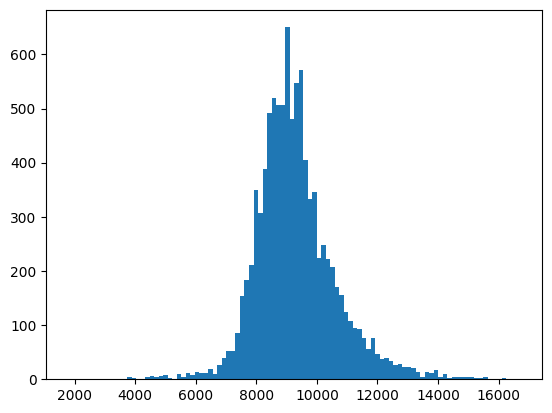

In [6]:
# 回帰問題として解くときの目的変数
train["target"] = (train["timestamp"] - train["start_time"]).dt.total_seconds() // 5 # [step]
plt.hist(train["target"], bins=100)
plt.show()

In [7]:
train.to_csv("train_base.csv", index=False)